In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
#selecting gpu instead of cpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Setting random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

In [ ]:
class ESM_Tracker:
    #track Estimation Shift Magnitude during training
    def __init__(self):
        self.expected_stats = {}
        self.estimated_stats = {}
        self.esm_history = {}

    def update_expected(self, layer_name, input_data):
        """Calculate expected statistics on current batch"""
        if layer_name not in self.expected_stats:
            self.expected_stats[layer_name] = {'mean': [], 'var': []}

        #calculate the statistics for current batch (what we "expect")
        if len(input_data.shape) == 4:  # CNN case
            mean = input_data.mean(dim=(0, 2, 3))
            var = input_data.var(dim=(0, 2, 3))
        else:  # MLP case
            mean = input_data.mean(dim=0)
            var = input_data.var(dim=0)

        self.expected_stats[layer_name]['mean'].append(mean.detach())
        self.expected_stats[layer_name]['var'].append(var.detach())

    def update_estimated(self, layer_name, bn_layer):
        """Get estimated statistics from BN running averages"""
        if layer_name not in self.estimated_stats:
            self.estimated_stats[layer_name] = {'mean': [], 'var': []}

        self.estimated_stats[layer_name]['mean'].append(bn_layer.running_mean.detach().clone())
        self.estimated_stats[layer_name]['var'].append(bn_layer.running_var.detach().clone())

    def calculate_esm(self, layer_name):
        """Calculate Estimation Shift Magnitude"""
        if layer_name not in self.expected_stats or layer_name not in self.estimated_stats:
            return 0, 0

        #use the most recent statistics
        exp_mean = self.expected_stats[layer_name]['mean'][-1]
        exp_var = self.expected_stats[layer_name]['var'][-1]
        est_mean = self.estimated_stats[layer_name]['mean'][-1]
        est_var = self.estimated_stats[layer_name]['var'][-1]

        esm_mean = torch.norm(exp_mean - est_mean, p=2).item()
        esm_var = torch.norm(torch.sqrt(exp_var + 1e-5) - torch.sqrt(est_var + 1e-5), p=2).item()

        #store history
        if layer_name not in self.esm_history:
            self.esm_history[layer_name] = {'mean': [], 'var': []}

        self.esm_history[layer_name]['mean'].append(esm_mean)
        self.esm_history[layer_name]['var'].append(esm_var)

        return esm_mean, esm_var

class XBNBlock(nn.Module):
    """XBNBlock with BFN at position 2 (P2)"""
    def __init__(self, in_channels, out_channels, stride=1, bfn_type='GN'):
        super(XBNBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels//4, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels//4)

        self.conv2 = nn.Conv2d(out_channels//4, out_channels//4, 3, stride=stride, padding=1, bias=False)
        #this is where we put BFN instead of BN (XBNBlock-P2, meaning Position 2 placement)
        if bfn_type == 'GN':
            self.norm2 = nn.GroupNorm(32, out_channels//4)  #GroupNorm as BFN
        else:  #InstanceNorm
            self.norm2 = nn.InstanceNorm2d(out_channels//4)

        self.conv3 = nn.Conv2d(out_channels//4, out_channels, 1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.norm2(self.conv2(out)))  #BFN here
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self, use_xbn=False):
        super(SimpleCNN, self).__init__()
        self.use_xbn = use_xbn
        self.esm_tracker = ESM_Tracker()

        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)

        if use_xbn:
            self.block1 = XBNBlock(64, 128)
            self.block2 = XBNBlock(128, 256)
        else:
            #create proper residual blocks for vanilla model
            self.block1 = self._make_vanilla_res_block(64, 128)
            self.block2 = self._make_vanilla_res_block(128, 256)

        self.fc = nn.Linear(256 * 8 * 8, 10)
        self.layers_to_track = ['bn1', 'block1.bn1', 'block1.bn3', 'block2.bn1', 'block2.bn3']

    def _make_vanilla_res_block(self, in_channels, out_channels):
        """Create a residual block similar to XBNBlock but with all BNs"""
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels//4, 1, bias=False),
            nn.BatchNorm2d(out_channels//4),
            nn.ReLU(),
            nn.Conv2d(out_channels//4, out_channels//4, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels//4),  # This will be position P2
            nn.ReLU(),
            nn.Conv2d(out_channels//4, out_channels, 1, bias=False),
            nn.BatchNorm2d(out_channels)
        )

    def forward(self, x, track_esm=False, epoch=0):
        #Layer 1
        out = self.conv1(x)
        if track_esm:
            self.esm_tracker.update_expected('bn1', out)
        out = self.bn1(out)
        if track_esm:
            self.esm_tracker.update_estimated('bn1', self.bn1)
        out = F.relu(out)
        out = F.max_pool2d(out, 2)

        #Blocks
        out = self.block1(out)
        out = self.block2(out)

        out = F.adaptive_avg_pool2d(out, (8, 8))
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [ ]:
def train_model(model, train_loader, test_loader, epochs=50, model_name='vanilla'):
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    train_losses = []
    test_accuracies = []
    esm_history = {name: [] for name in model.layers_to_track}

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}')

        for batch_idx, (data, target) in enumerate(progress_bar):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data, track_esm=(batch_idx % 10 == 0))  # Track ESM periodically
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            progress_bar.set_postfix({'Loss': f'{loss.item():.4f}'})

        # Calculate ESM at end of epoch
        if epoch % 5 == 0:  # Track ESM every 5 epochs
            with torch.no_grad():
        # Simple ESM tracking for just the first BN layer
                if hasattr(model, 'bn1'):
             # Use a dummy forward pass to get expected stats
                    dummy_data = next(iter(train_loader))[0][:1]  # Single sample
                    _ = model(dummy_data, track_esm=True)
                    esm_m, esm_v = model.esm_tracker.calculate_esm('bn1')
                    esm_history['bn1'].append(esm_v)

        # Test accuracy
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for data, target in test_loader:
                output = model(data)
                _, predicted = torch.max(output.data, 1)
                total += target.size(0)
                correct += (predicted == target).sum().item()

        accuracy = 100 * correct / total
        test_accuracies.append(accuracy)
        train_losses.append(total_loss / len(train_loader))

        print(f'Epoch {epoch+1}: Loss = {train_losses[-1]:.4f}, Test Acc = {accuracy:.2f}%')

    return train_losses, test_accuracies, esm_history

In [ ]:
def test_robustness(model, test_loader, noise_levels=[0.0, 0.1, 0.2, 0.3, 0.4]):
    """Test model robustness to noise in BN statistics"""
    original_stats = {}

    # Save original BN statistics
    for name, module in model.named_modules():
        if isinstance(module, nn.BatchNorm2d):
            original_stats[name] = {
                'running_mean': module.running_mean.clone(),
                'running_var': module.running_var.clone()
            }

    accuracies = []
    confidences = []  # We'll track predictive entropy

    for noise_magnitude in noise_levels:
        # Add noise to BN statistics
        for name, module in model.named_modules():
            if isinstance(module, nn.BatchNorm2d):
                module.running_mean = original_stats[name]['running_mean'] * (
                    1 + torch.randn_like(original_stats[name]['running_mean']) * noise_magnitude
                )
                module.running_var = original_stats[name]['running_var'] * (
                    1 + torch.randn_like(original_stats[name]['running_var']) * noise_magnitude
                )

        # Test accuracy with noisy stats
        model.eval()
        correct = 0
        total = 0
        all_entropies = []

        with torch.no_grad():
            for data, target in test_loader:
                output = model(data)
                probabilities = F.softmax(output, dim=1)

                # Calculate predictive entropy
                entropy = -torch.sum(probabilities * torch.log(probabilities + 1e-8), dim=1)
                all_entropies.extend(entropy.cpu().numpy())

                _, predicted = torch.max(output.data, 1)
                total += target.size(0)
                correct += (predicted == target).sum().item()

        accuracy = 100 * correct / total
        avg_entropy = np.mean(all_entropies)

        accuracies.append(accuracy)
        confidences.append(avg_entropy)

        print(f'Noise {noise_magnitude:.1f}: Accuracy = {accuracy:.2f}%, Avg Entropy = {avg_entropy:.4f}')

    # Restore original statistics
    for name, module in model.named_modules():
        if isinstance(module, nn.BatchNorm2d):
            module.running_mean = original_stats[name]['running_mean']
            module.running_var = original_stats[name]['running_var']

    return accuracies, confidences, noise_levels

In [ ]:
def main():
    # Data loading
    print("Loading CIFAR-10 dataset...")
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True)

    testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False)

    # Train vanilla model (with fewer epochs for testing)
    print("\n=== Training Vanilla CNN ===")
    vanilla_model = SimpleCNN(use_xbn=False)
    vanilla_model = vanilla_model.to(device)
    vanilla_loss, vanilla_acc, vanilla_esm = train_model(vanilla_model, train_loader, test_loader, epochs=10, model_name='vanilla')

    # Train XBNBlock model
    print("\n=== Training XBNBlock CNN ===")
    xbn_model = SimpleCNN(use_xbn=True)
    xbn_model = xbn_model.to(device)
    xbn_loss, xbn_acc, xbn_esm = train_model(xbn_model, train_loader, test_loader, epochs=10, model_name='xbn')

    # Test robustness
    print("\n=== Testing Robustness ===")
    vanilla_accuracies, vanilla_entropies, noise_levels = test_robustness(vanilla_model, test_loader)
    xbn_accuracies, xbn_entropies, _ = test_robustness(xbn_model, test_loader)

    return {
        'vanilla': {'acc': vanilla_acc, 'loss': vanilla_loss, 'esm': vanilla_esm,
                   'robust_acc': vanilla_accuracies, 'robust_entropy': vanilla_entropies},
        'xbn': {'acc': xbn_acc, 'loss': xbn_loss, 'esm': xbn_esm,
               'robust_acc': xbn_accuracies, 'robust_entropy': xbn_entropies},
        'noise_levels': noise_levels
    }

# Run the experiment
results = main()

Loading CIFAR-10 dataset...


100%|██████████| 170M/170M [00:07<00:00, 21.9MB/s]



=== Training Vanilla CNN ===


Epoch 1/10: 100%|██████████| 391/391 [07:34<00:00,  1.16s/it, Loss=1.0111]


Epoch 1: Loss = 1.2808, Test Acc = 60.67%


Epoch 2/10: 100%|██████████| 391/391 [07:32<00:00,  1.16s/it, Loss=0.8578]


Epoch 2: Loss = 0.8839, Test Acc = 68.01%


Epoch 3/10: 100%|██████████| 391/391 [07:29<00:00,  1.15s/it, Loss=0.8288]


Epoch 3: Loss = 0.7519, Test Acc = 70.72%


Epoch 4/10: 100%|██████████| 391/391 [07:30<00:00,  1.15s/it, Loss=0.5986]


Epoch 4: Loss = 0.6646, Test Acc = 71.97%


Epoch 5/10: 100%|██████████| 391/391 [07:32<00:00,  1.16s/it, Loss=0.7985]


Epoch 5: Loss = 0.5979, Test Acc = 73.49%


Epoch 6/10: 100%|██████████| 391/391 [07:31<00:00,  1.16s/it, Loss=0.5270]


Epoch 6: Loss = 0.5365, Test Acc = 72.04%


Epoch 7/10: 100%|██████████| 391/391 [07:26<00:00,  1.14s/it, Loss=0.3551]


Epoch 7: Loss = 0.4879, Test Acc = 73.20%


Epoch 8/10: 100%|██████████| 391/391 [07:35<00:00,  1.17s/it, Loss=0.4017]


Epoch 8: Loss = 0.4507, Test Acc = 73.86%


Epoch 9/10: 100%|██████████| 391/391 [07:39<00:00,  1.18s/it, Loss=0.4816]


Epoch 9: Loss = 0.4133, Test Acc = 74.55%


Epoch 10/10: 100%|██████████| 391/391 [07:31<00:00,  1.16s/it, Loss=0.4903]


Epoch 10: Loss = 0.3708, Test Acc = 73.01%

=== Training XBNBlock CNN ===


Epoch 1/10: 100%|██████████| 391/391 [10:17<00:00,  1.58s/it, Loss=1.0442]


Epoch 1: Loss = 1.4089, Test Acc = 66.39%


Epoch 2/10: 100%|██████████| 391/391 [09:36<00:00,  1.47s/it, Loss=0.7934]


Epoch 2: Loss = 0.8106, Test Acc = 71.23%


Epoch 3/10: 100%|██████████| 391/391 [09:46<00:00,  1.50s/it, Loss=0.6828]


Epoch 3: Loss = 0.6562, Test Acc = 74.60%


Epoch 4/10: 100%|██████████| 391/391 [09:50<00:00,  1.51s/it, Loss=0.2850]


Epoch 4: Loss = 0.5567, Test Acc = 75.38%


Epoch 5/10: 100%|██████████| 391/391 [10:14<00:00,  1.57s/it, Loss=0.5407]


Epoch 5: Loss = 0.4690, Test Acc = 74.51%


Epoch 6/10: 100%|██████████| 391/391 [10:21<00:00,  1.59s/it, Loss=0.4000]


Epoch 6: Loss = 0.3937, Test Acc = 76.14%


Epoch 7/10: 100%|██████████| 391/391 [10:04<00:00,  1.55s/it, Loss=0.3253]


Epoch 7: Loss = 0.3277, Test Acc = 76.08%


Epoch 8/10: 100%|██████████| 391/391 [11:18<00:00,  1.74s/it, Loss=0.1689]


Epoch 8: Loss = 0.2681, Test Acc = 76.83%


Epoch 9/10: 100%|██████████| 391/391 [10:27<00:00,  1.60s/it, Loss=0.2244]


Epoch 9: Loss = 0.2183, Test Acc = 77.35%


Epoch 10/10: 100%|██████████| 391/391 [10:07<00:00,  1.55s/it, Loss=0.2671]


Epoch 10: Loss = 0.1810, Test Acc = 77.23%

=== Testing Robustness ===
Noise 0.0: Accuracy = 73.01%, Avg Entropy = 0.4346
Noise 0.1: Accuracy = 67.68%, Avg Entropy = 0.3920
Noise 0.2: Accuracy = 64.21%, Avg Entropy = 0.4034
Noise 0.3: Accuracy = 28.01%, Avg Entropy = 0.2797
Noise 0.4: Accuracy = 43.32%, Avg Entropy = 0.3251
Noise 0.0: Accuracy = 77.23%, Avg Entropy = 0.3099
Noise 0.1: Accuracy = 74.86%, Avg Entropy = 0.3260
Noise 0.2: Accuracy = 74.30%, Avg Entropy = 0.3337
Noise 0.3: Accuracy = 10.00%, Avg Entropy = nan
Noise 0.4: Accuracy = 10.00%, Avg Entropy = nan


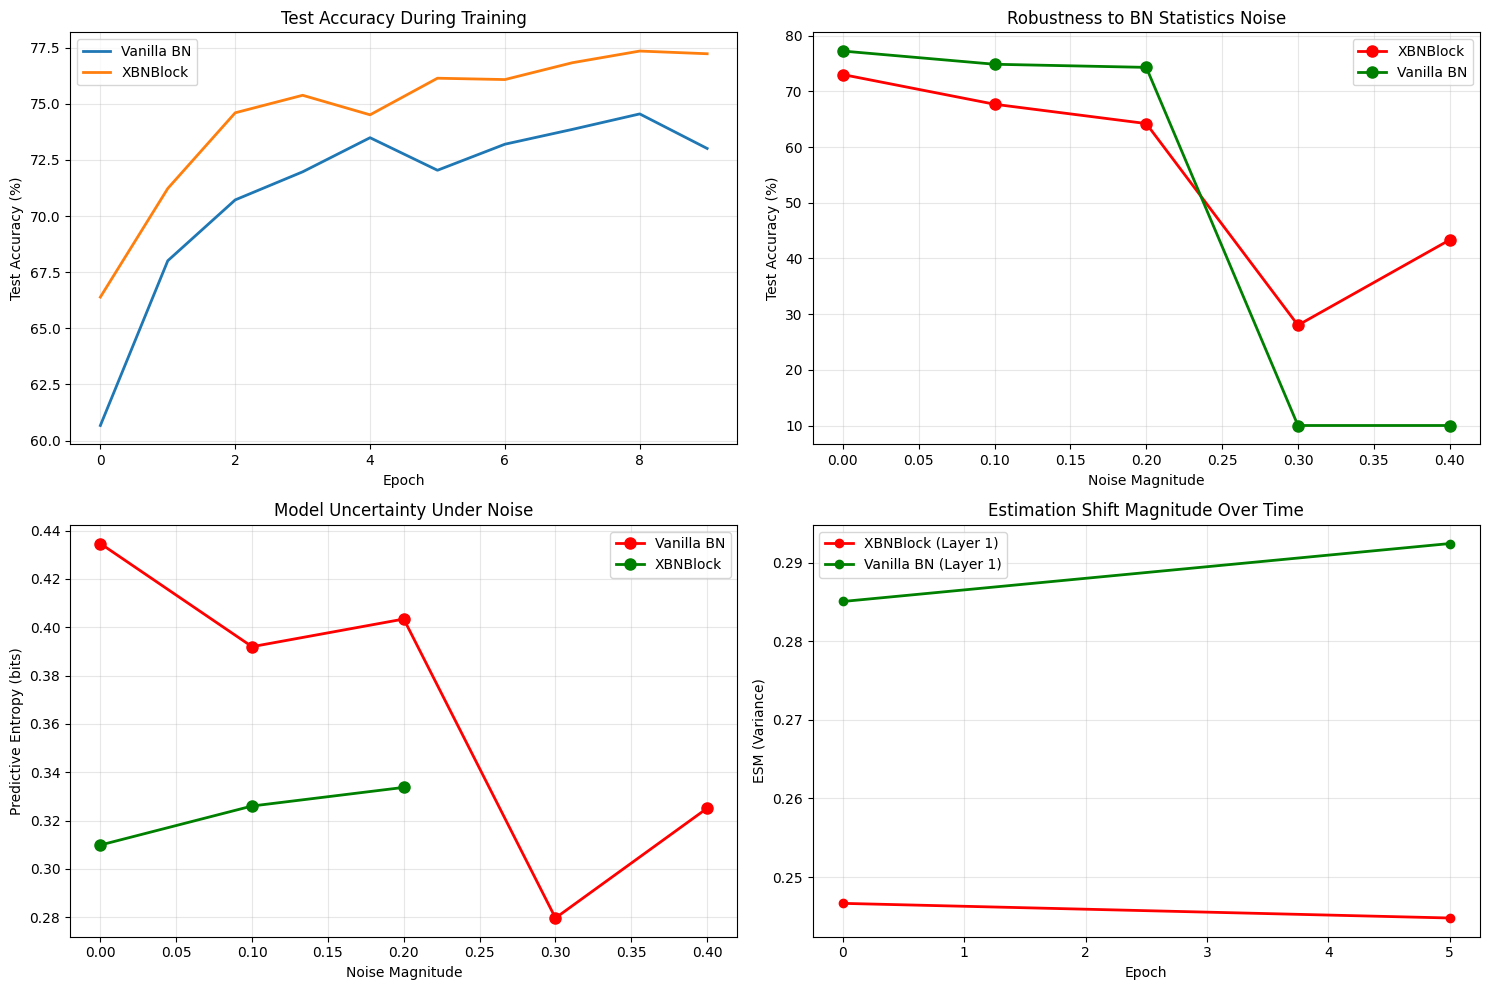

In [ ]:
def plot_results(results):
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

    #test Accuracy during training
    ax1.plot(results['vanilla']['acc'], label='Vanilla BN', linewidth=2)
    ax1.plot(results['xbn']['acc'], label='XBNBlock', linewidth=2)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Test Accuracy (%)')
    ax1.set_title('Test Accuracy During Training')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    #robustness to BN noise (Accuracy)
    ax2.plot(results['noise_levels'], results['vanilla']['robust_acc'], 'ro-', label='XBNBlock', linewidth=2, markersize=8)
    ax2.plot(results['noise_levels'], results['xbn']['robust_acc'], 'go-', label='Vanilla BN', linewidth=2, markersize=8)
    ax2.set_xlabel('Noise Magnitude')
    ax2.set_ylabel('Test Accuracy (%)')
    ax2.set_title('Robustness to BN Statistics Noise')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    #predictive Entropy under noise
    ax3.plot(results['noise_levels'], results['vanilla']['robust_entropy'], 'ro-', label='Vanilla BN', linewidth=2, markersize=8)
    ax3.plot(results['noise_levels'], results['xbn']['robust_entropy'], 'go-', label='XBNBlock', linewidth=2, markersize=8)
    ax3.set_xlabel('Noise Magnitude')
    ax3.set_ylabel('Predictive Entropy (bits)')
    ax3.set_title('Model Uncertainty Under Noise')
    ax3.legend()
    ax3.grid(True, alpha=0.3)

    #ESM accumulation
    if 'bn1' in results['vanilla']['esm']:
        vanilla_esm_data = results['vanilla']['esm']['bn1']
        xbn_esm_data = results['xbn']['esm']['bn1']

        #create matching x-axis for the available ESM data
        epochs_tracked = range(0, len(vanilla_esm_data) * 5, 5)  #track every 5 epochs

        ax4.plot(epochs_tracked, vanilla_esm_data, 'ro-', label='XBNBlock (Layer 1)', linewidth=2, markersize=6)
        ax4.plot(epochs_tracked, xbn_esm_data, 'go-', label='Vanilla BN (Layer 1)', linewidth=2, markersize=6)

        ax4.set_xlabel('Epoch')
        ax4.set_ylabel('ESM (Variance)')
        ax4.set_title('Estimation Shift Magnitude Over Time')
        ax4.legend()
        ax4.grid(True, alpha=0.3)
    else:
        ax4.text(0.5, 0.5, 'No ESM Data Available', ha='center', va='center', transform=ax4.transAxes)
        ax4.set_title('Estimation Shift Magnitude (No Data)')

    plt.tight_layout()
    plt.savefig('xbnblock_results.png', dpi=300, bbox_inches='tight')
    plt.show()

#plot the results
plot_results(results)